<center><img src="https://i.imgur.com/zRrFdsf.png" width="700"></center>

<a target="_blank" href="https://colab.research.google.com/github/CienciaDeDatosEspacial/geodfprepro/blob/main/GeoDF_Operations.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Basic spatial operations in  Geo Dataframes

We will review some important formatting processes for geodataframes. As usual, let's do this: 

1. Create a repository named: **geodfprepro**.
2. Clone that repo to a local folder in your computer.
3. In that local folder in your computer, create a folder named **maps** and **data**.
4. Put the **brazilMaps_5641.gpkg**  file that contains the three maps prepared last class into the map folder.
5. Download the shapefile of "Brazil - Subnational Administrative Boundaries" from [here](https://data.humdata.org/dataset/cod-ab-bra) and save it in the maps folder (you need to unzip the file).
6. Download a **CSV** file with information on the airports in Brazil from this [website](https://data.humdata.org/dataset/ourairports-bra), I will save it in my **data** folder:
7. Commit and push.

Let's read _Brazil_5641.gpkg_ from the GitHub link with the help of **geopandas**:

In [1]:
import os


import geopandas as gpd
from  fiona import listlayers

#maps
brazilMaps='https://github.com/CienciaDeDatosEspacial/geodfprepro/raw/main/maps/brazilMaps_5641.gpkg'

#layers in maps
listlayers(brazilMaps)

['country', 'cities', 'rivers']

Retrieving each map (layer):

In [2]:
brazil=gpd.read_file(brazilMaps,layer='country')
brazil_cities=gpd.read_file(brazilMaps,layer='cities')
brazil_rivers=gpd.read_file(brazilMaps,layer='rivers')

We know they share the same CRS:

In [3]:
brazil.crs.to_epsg()==brazil_cities.crs.to_epsg()==brazil_rivers.crs.to_epsg()

True

We also remember that having the same CRS allows one plot with several layers of maps:

<Axes: >

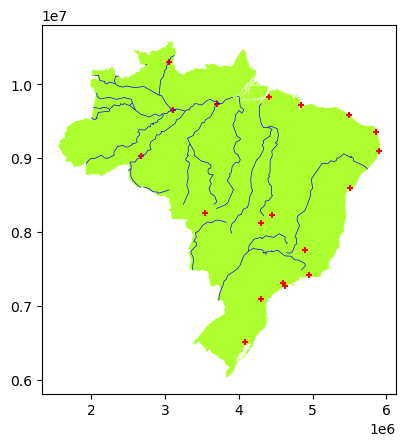

In [4]:
# plotting
base = brazil.plot(facecolor="greenyellow")
brazil_rivers.plot(edgecolor='blue', linewidth=0.5,ax=base)
brazil_cities.plot(marker='+', color='red', markersize=15,ax=base)

Now, let's see some important spatial operations:

1. [Formatting Projection](#1)
    * [Projecting Geoseries](#11) 
    * [Projecting Naive Geodata](#12)
    * [Projecting long/lat](#13)
    
2. [Combining GeoDF rows](#2)
    * [Dissolving](#21) 
    * [Unary union](#22)
      
4. [Creating Spatial Points](#3)
    * [Creating a convex hull](#31)
5. [Checking Validity](#4)



<a class="anchor" id="11"></a>

## Formating Geoseries projections



You know **brazil_5641** is a multipolygon:

In [5]:
brazil

COUNTRY                                           geometry
0  Brazil  MULTIPOLYGON (((1926257.542 8894978.397, 19262...

Sometime, you just need the border (lines):

In [6]:
brazil.boundary    

0    MULTILINESTRING ((1926257.542 8894978.397, 192...
dtype: geometry

<Axes: >

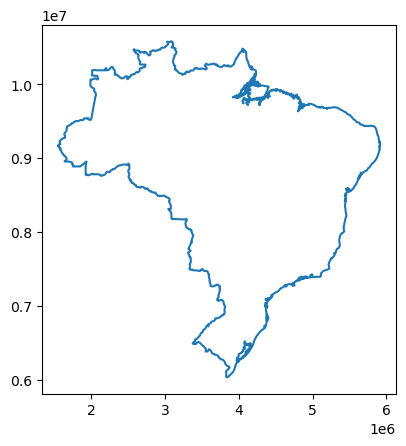

In [7]:
# This is just the borderline
brazil.boundary.plot()

Always check the data type:

In [8]:
# does 'boundary' return a GDF?
type(brazil.boundary)

geopandas.geoseries.GeoSeries

Some operations in geopandas require GDF or GS. If you need a GDF instead of a GS:

In [9]:
# converting into GDF
brazil.boundary.to_frame()

0
0  MULTILINESTRING ((1926257.542 8894978.397, 192...

Notice you get a very simple GDF, and you may want to add some information:

In [10]:
# conversion
brazil_border=brazil.boundary.to_frame() # tengo un DFbrazil_border

# new column (optional)
brazil_border['name']='Brazil' 

# renaming the geometry column
brazil_border.rename(columns={0:'geometry'},inplace=True) 

#setting the geometry (the name is not enough)
brazil_border = brazil_border.set_geometry("geometry")

# verifying:
brazil_border.crs

<Projected CRS: EPSG:5641>
Name: SIRGAS 2000 / Brazil Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Brazil - offshore - equatorial margin.
- bounds: (-51.64, -5.74, -32.43, 7.04)
Coordinate Operation:
- name: Petrobras Mercator
- method: Mercator (variant B)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

You see you _multistring_:

In [11]:
brazil_border

geometry    name
0  MULTILINESTRING ((1926257.542 8894978.397, 192...  Brazil

You can add this GDF as a layer:

### Exercise 1

<div class="alert-success"> 
    
1. Check if your country is a polygon or multipolygon.
    
2. Recover just the boundaries of that country.
    
3. Turn the boundary into a GDF.
</div>

<a class="anchor" id="12"></a>

## Lacking CRS information

Reprojecting seems a simple process, but you might find some interesting cases. Let's read the maps on _states_ and _municipalities_:

In [12]:
brazil_states=gpd.read_file(os.path.join("maps","bra_adm_ibge_2020_shp","bra_admbnda_adm1_ibge_2020.shp"))
brazil_municipalities=gpd.read_file(os.path.join("maps","bra_adm_ibge_2020_shp","bra_admbnda_adm2_ibge_2020.shp"))

Notice this:

In [13]:
brazil_states.crs, brazil_municipalities.crs

(None, None)

They do not have crs information, however they can be plotted:

<Axes: >

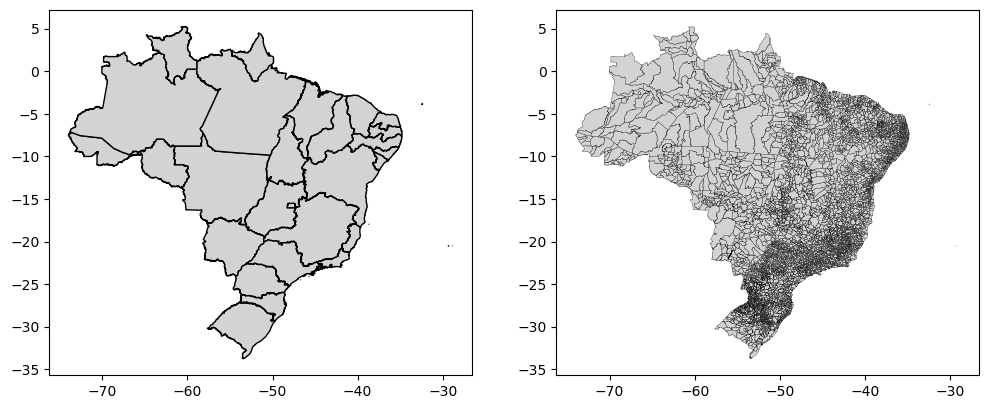

In [14]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(12,12))

brazil_states.plot(ax=ax1, facecolor='lightgrey', edgecolor='black')
brazil_municipalities.plot(ax=ax2, facecolor='lightgrey', edgecolor='black',linewidth=0.2)


Since we are using the crs 5641 for Brazil, the initial strategy could be to set the CRS with the right projection :

In [15]:
# brazil_states.to_crs(5641)

Python says _"Please set a crs on the object first"_. This would mean to know the actual projection, of the geometry:

In [16]:
brazil_states.geometry.head()

0    MULTIPOLYGON (((-68.87747 -11.01987, -68.88027...
1    POLYGON ((-35.46317 -8.82467, -35.46457 -8.828...
2    MULTIPOLYGON (((-50.46147 2.11133, -50.45627 2...
3    MULTIPOLYGON (((-58.49367 -0.84197, -58.48917 ...
4    MULTIPOLYGON (((-38.70687 -17.96447, -38.70867...
Name: geometry, dtype: geometry

From the plots above and the previous rows, we conclude the maps are unprojected map; then:

In [17]:
brazil_states.crs = "EPSG:4326"
brazil_municipalities.crs = "EPSG:4326"

Now, we can reproject:

In [18]:
brazil_states=brazil_states.to_crs(5641)
brazil_municipalities=brazil_municipalities.to_crs(5641)

### Exercise 2

<div class="alert-success">

1. Look for sub administrative divisions of your country
2. Check all the CRSs of those divisions
3. If you find one CRS is missing, fill the CRS with the right projection.
</div>

<a class="anchor" id="13"></a>

## Projecting Lat/Lon Points

You will get Lines and Polygons as maps for sure, but that may not be the case with points. These points came as a CSV file:

In [19]:
import pandas as pd 
infoairports=pd.read_csv(os.path.join("data","br-airports.csv"))

# see

infoairports

id        ident                 type  \
0     #meta +id  #meta +code  #loc +airport +type   
1          5910         SBGR        large_airport   
2          5906         SBGL        large_airport   
3          5974         SBSP       medium_airport   
4          5967         SBRJ       medium_airport   
...         ...          ...                  ...   
6862     309669         SSVR               closed   
6863     505308      BR-1760             heliport   
6864     341727      BR-1429             heliport   
6865     343017      BR-1493             heliport   
6866     509863         SN3D             heliport   

                                                   name latitude_deg  \
0                                   #loc +airport +name    #geo +lat   
1     Guarulhos - Governador André Franco Montoro In...   -23.431944   
2          Rio Galeão – Tom Jobim International Airport   -22.809999   
3                                     Congonhas Airport   -23.627657   
4                                 Santos Dumont Airport     -22.9105   
...                                                 ...          ...   
6862                              Volta Redonda Airport     -22.4978   
6863                       Unimed Volta Redonda Helipad   -22.533988   
6864                              Santa Helena Heliport    -23.59851   
6865              Bandeiras Centro Empresarial Heliport   -23.536615   
6866               Alphaville Nova Esplanada 2 Heliport   -23.558971   

     longitude_deg         elevation_ft                 continent  \
0        #geo +lon  #geo +elevation +ft  #region +continent +code   
1       -46.467778                 2461                        SA   
2       -43.250557                   28                        SA   
3       -46.654601                 2631                        SA   
4       -43.163101                   11                        SA   
...            ...                  ...                       ...   
6862       -44.085                 1245                        SA   
6863    -44.076918                 1385                        SA   
6864    -47.441196                 2254                        SA   
6865    -47.449475                 1827                        SA   
6866    -47.473779                 2083                        SA   

        country_name           iso_country  ...              municipality  \
0     #country +name  #country +code +iso2  ...  #loc +municipality +name   
1             Brazil                    BR  ...                 São Paulo   
2             Brazil                    BR  ...            Rio De Janeiro   
3             Brazil                    BR  ...                 São Paulo   
4             Brazil                    BR  ...            Rio de Janeiro   
...              ...                   ...  ...                       ...   
6862          Brazil                    BR  ...             Volta Redonda   
6863          Brazil                    BR  ...             Volta Redonda   
6864          Brazil                    BR  ...                Votorantim   
6865          Brazil                    BR  ...                Votorantim   
6866          Brazil                    BR  ...                Votorantim   

       scheduled_service                  gps_code                  iata_code  \
0     #status +scheduled  #loc +airport +code +gps  #loc +airport +code +iata   
1                      1                      SBGR                        GRU   
2                      1                      SBGL                        GIG   
3                      1                      SBSP                        CGH   
4                      1                      SBRJ                        SDU   
...                  ...                       ...                        ...   
6862                   0                       NaN                        NaN   
6863                   0                      SSKV                        NaN   
6864                   0    

In [20]:
# un archivo excel debo convertirlo a un archivo espacial para trabajar lo que hemos visto en el curso

This needs some cleaning, as the first row has column names, and some columns are not needed:

In [21]:
# bye first row 
infoairports.drop(index=0,inplace=True)
infoairports.reset_index(drop=True, inplace=True)

# keep the  columns needed
keep=['name','type','latitude_deg', 'longitude_deg','elevation_ft','region_name','municipality']
infoairports=infoairports.loc[:,keep]
infoairports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6866 entries, 0 to 6865
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           6866 non-null   object
 1   type           6866 non-null   object
 2   latitude_deg   6866 non-null   object
 3   longitude_deg  6866 non-null   object
 4   elevation_ft   6696 non-null   object
 5   region_name    6866 non-null   object
 6   municipality   6842 non-null   object
dtypes: object(7)
memory usage: 375.6+ KB


Some formatting is needed, because numeric data columns are not the right type:

In [22]:
numericCols=['latitude_deg', 'longitude_deg','elevation_ft']
infoairports[numericCols]=infoairports.loc[:,numericCols].apply(lambda x:pd.to_numeric(x))

# now 
infoairports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6866 entries, 0 to 6865
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6866 non-null   object 
 1   type           6866 non-null   object 
 2   latitude_deg   6866 non-null   float64
 3   longitude_deg  6866 non-null   float64
 4   elevation_ft   6696 non-null   float64
 5   region_name    6866 non-null   object 
 6   municipality   6842 non-null   object 
dtypes: float64(3), object(4)
memory usage: 375.6+ KB


<Axes: xlabel='longitude_deg', ylabel='latitude_deg'>

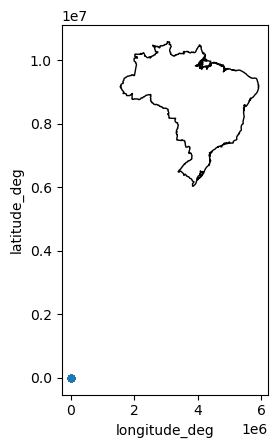

In [23]:
# let's plot

base = brazil.plot(color='white', edgecolor='black') #unprojected

infoairports.plot.scatter(x = 'longitude_deg', y = 'latitude_deg',ax=base)

We get it wrong because coordinates of both do not match. Let's try this:

1. Create a GeoDataFrame with the points, keeping them unprojected:

In [24]:
airports=gpd.GeoDataFrame(data=infoairports.copy(),
                 geometry=gpd.points_from_xy(infoairports.longitude_deg,
                                             infoairports.latitude_deg), 
                 crs=4326)# the coordinates were in degrees - unprojected

2. Reproject the GeoDataFrame:

In [25]:
airports=airports.to_crs(5641)

Does it look better?

<Axes: >

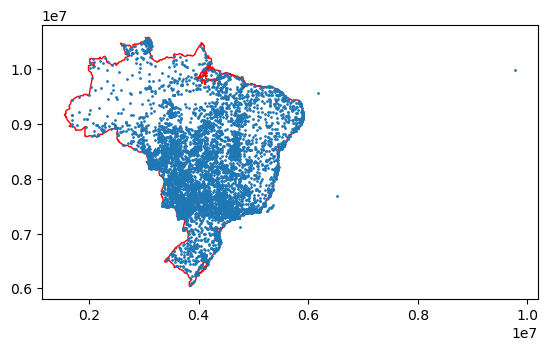

In [26]:
# let's plot

base = brazil.plot(color='white', edgecolor='red')
airports.plot(ax=base,markersize=1)

Now we have a spatial points:

In [27]:
#remember:
type(airports), type(infoairports)

(geopandas.geodataframe.GeoDataFrame, pandas.core.frame.DataFrame)

Remember you have type of airports:

In [28]:
airports['type'].value_counts() # this will not work: airports.type.value_counts()

type
small_airport     4713
heliport          1745
closed             272
medium_airport     124
large_airport       10
seaplane_base        2
Name: count, dtype: int64

We may use that in the future. For now, just give the **type** column a different name.

In [29]:
airports.rename(columns={'type':'kind'},inplace=True)

Let's play with this:

In [30]:
from folium import LayerControl


m = airports[airports.kind=='small_airport'].explore(color="red",name="small",show=False)
m = airports[airports.kind=='medium_airport'].explore(m=m, color="blue",name="medium",show=False)
m = airports[airports.kind=='large_airport'].explore(m=m, color="black",name="large",show=True)
m = airports[airports.kind=='seaplane_base'].explore(m=m, color="green",name="seaplane",show=False)
m = airports[airports.kind=='closed'].explore(m=m, color="white",name="closed",show=False)
m = airports[airports.kind=='heliport'].explore(m=m, color="orange",name="heliport",show=False)

LayerControl(collapsed=False).add_to(m) #optional

m


### Exercise 3 
<div class="alert-success">

1. Look for some points in a CSV file about your country.
    
2. Turn those points into a spatial object.
    
3. Save the layer.
    
</div>

<a class="anchor" id="2"></a>

## Combing GeoDF rows

Let me divide Brazil municipalities using the centroid of Brazil:

In [31]:
centroBrazil=brazil.centroid
centroBrazil

0    POINT (3884486.179 8756856.093)
dtype: geometry

Notice:

In [32]:
type(centroBrazil), type(centroBrazil.x)

(geopandas.geoseries.GeoSeries, pandas.core.series.Series)

The previous values are complex structures, not simple values. Then:

In [33]:
type(centroBrazil.x[0]),type(centroBrazil.y[0])

(numpy.float64, numpy.float64)

Let me now subset using  geopandas'  **cx**, which does subsetting **by location**:

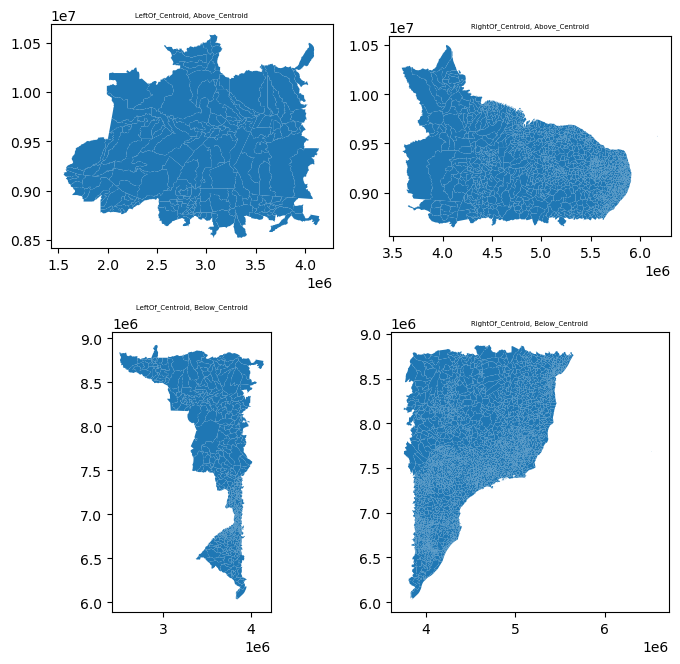

In [34]:
fig, axs = plt.subplots(nrows=2,ncols=2,sharex=False, sharey=False,figsize=(8,8))

centroidX=centroBrazil.x[0]
centroidY=centroBrazil.y[0]

axs[0,0].set_title('LeftOf_Centroid, Above_Centroid',fontsize=5)
brazil_municipalities.cx[:centroidX,centroidY:].plot(ax=axs[0,0]) 

axs[0,1].set_title('RightOf_Centroid, Above_Centroid',fontsize=5)
brazil_municipalities.cx[centroidX:,centroidY:].plot(ax=axs[0,1]) 

axs[1,0].set_title('LeftOf_Centroid, Below_Centroid',fontsize=5)
brazil_municipalities.cx[:centroidX,:centroidY].plot(ax=axs[1,0]) 

axs[1,1].set_title('RightOf_Centroid, Below_Centroid',fontsize=5)
brazil_municipalities.cx[centroidX:,:centroidY].plot(ax=axs[1,1]) ;

You can create a polygon with one of these:

In [35]:
#instead of:
brazil_municipalities.cx[:centroidX,centroidY:]

ADM0_EN ADM0_PT ADM0_PCODE      ADM1_PT ADM1_PCODE  \
1     Brazil  Brasil         BR     Rondônia       BR11   
3     Brazil  Brasil         BR     Rondônia       BR11   
8     Brazil  Brasil         BR     Rondônia       BR11   
9     Brazil  Brasil         BR     Rondônia       BR11   
10    Brazil  Brasil         BR     Rondônia       BR11   
...      ...     ...        ...          ...        ...   
5305  Brazil  Brasil         BR  Mato Grosso       BR51   
5310  Brazil  Brasil         BR  Mato Grosso       BR51   
5313  Brazil  Brasil         BR  Mato Grosso       BR51   
5321  Brazil  Brasil         BR  Mato Grosso       BR51   
5324  Brazil  Brasil         BR  Mato Grosso       BR51   

                    ADM2_PT ADM2_PCODE  ET_ID  \
1                 Ariquemes  BR1100023      1   
3                    Cacoal  BR1100049      3   
8           Espigão D'Oeste  BR1100098      8   
9             Guajará-Mirim  BR1100106      9   
10                     Jaru  BR1100114     10   
...                     ...        ...    ...   
5305  São Félix do Araguaia  BR5107859   5305   
5310               Tabaporã  BR5107941   5310   
5313    Terra Nova do Norte  BR5108055   5313   
5321           Nova Guarita  BR5108808   5321   
5324       Nova Monte Verde  BR5108956   5324   

                                               geometry  
1     POLYGON ((2839173.154 8911097.984, 2838718.204...  
3     POLYGON ((2997393.730 8777661.276, 2997393.730...  
8     POLYGON ((3057637.194 8777929.305, 3056978.535...  
9     MULTIPOLYGON (((2708460.048 8727087.796, 27089...  
10    POLYGON ((2871236.909 8863979.571, 2871101.103...  
...                                                 ...  
5305  POLYGON ((3974265.397 8773180.057, 3974197.494...  
5310  POLYGON ((3505714.931 8812411.339, 3505972.962...  
5313  POLYGON ((3647944.371 8863821.903, 3657430.408...  
5321  POLYGON ((3638016.966 8872883.250, 3638098.449...  
5324  POLYGON ((3449722.190 8896410.060, 3449477.739...  

[191 rows x 9 columns]

<a class="anchor" id="21"></a>

### Dissolve

Let's use **dissolve**:

In [36]:
# dissolving
brazil_municipalities.cx[:centroidX,centroidY:].dissolve()

geometry ADM0_EN ADM0_PT  \
0  MULTIPOLYGON (((2121072.695 8774540.983, 21207...  Brazil  Brasil   

  ADM0_PCODE   ADM1_PT ADM1_PCODE    ADM2_PT ADM2_PCODE  ET_ID  
0         BR  Rondônia       BR11  Ariquemes  BR1100023      1

The 191 rows from the previous GDF are now one, Notice that some columns may be meaningless. And the result is:

In [37]:
type(brazil_municipalities.cx[:centroidX,centroidY:].dissolve())

geopandas.geodataframe.GeoDataFrame

As a GeoDF we can plot:

<Axes: >

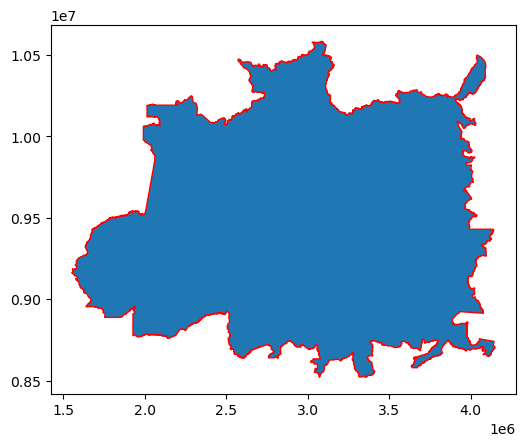

In [38]:
brazil_municipalities.cx[:centroidX,centroidY:].dissolve().plot(edgecolor='red')

By default, dissolve combines **all into one**, but dissolving also allows combining by other column; for example:

<Axes: >

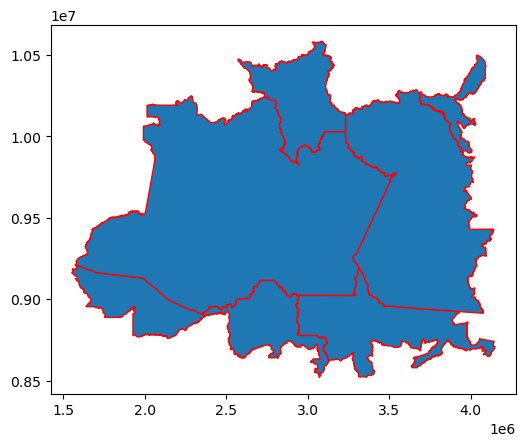

In [39]:
# the municipalities by state
brazil_municipalities.cx[:centroidX,centroidY:].dissolve(by='ADM1_PT').plot(edgecolor='red')

### Unary Union

This operation is used to combine all the geometries in one GeoDF:

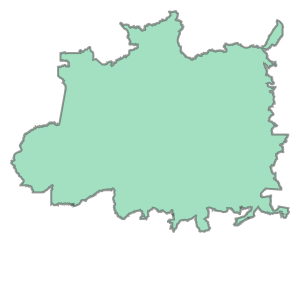

In [40]:
brazil_municipalities.cx[:centroidX,centroidY:].unary_union

It looks like dissolve default behaviour, but:

In [41]:
type(brazil_municipalities.cx[:centroidX,centroidY:].unary_union)

shapely.geometry.multipolygon.MultiPolygon

The result is not a GeoDF. It is a _shapely_ geometry. You could turn that into a GeoSeries:

In [42]:
gpd.GeoDataFrame(index=[0],
                 crs=brazil_municipalities.crs,
                 geometry=[brazil_municipalities.cx[:centroidX,centroidY:].unary_union])

geometry
0  MULTIPOLYGON (((2121072.695 8774540.983, 21207...

Notice that _unary union_ erase all other columns; it only produces the geometry combined. 

Let me use the dissolve this time:

In [43]:
# you create
Brazil_topLeft=brazil_municipalities.cx[:centroidX,centroidY:].dissolve()
# you get
Brazil_topLeft

geometry ADM0_EN ADM0_PT  \
0  MULTIPOLYGON (((2121072.695 8774540.983, 21207...  Brazil  Brasil   

  ADM0_PCODE   ADM1_PT ADM1_PCODE    ADM2_PT ADM2_PCODE  ET_ID  
0         BR  Rondônia       BR11  Ariquemes  BR1100023      1

Aside from the *ADM0_EN* and  *geometry* column, the rest is meaningless, then:

In [44]:
Brazil_topLeft['zone']='NW' # add column
Brazil_topLeft=Brazil_topLeft.loc[:,['ADM0_EN','zone','geometry']]   # keep some

# result
Brazil_topLeft

ADM0_EN zone                                           geometry
0  Brazil   NW  MULTIPOLYGON (((2121072.695 8774540.983, 21207...

We can do the same with the other parts:

In [45]:
Brazil_topRight=brazil_municipalities.cx[centroidX:,centroidY:].dissolve()
Brazil_bottomLeft=brazil_municipalities.cx[:centroidX,:centroidY].dissolve()
Brazil_bottomRight=brazil_municipalities.cx[centroidX:,:centroidY].dissolve()

Brazil_topRight['zone']='NE'
Brazil_topRight=Brazil_topRight.loc[:,['ADM0_EN','zone','geometry']] 

Brazil_bottomLeft['zone']='NE'
Brazil_bottomLeft=Brazil_bottomLeft.loc[:,['ADM0_EN','zone','geometry']] 

Brazil_bottomRight['zone']='NE'
Brazil_bottomRight=Brazil_bottomRight.loc[:,['ADM0_EN','zone','geometry']] 


Keep in mind that with **CX** you may not get a perfect partition:

In [46]:
brazil_municipalities

ADM0_EN ADM0_PT ADM0_PCODE           ADM1_PT ADM1_PCODE  \
0     Brazil  Brasil         BR          Rondônia       BR11   
1     Brazil  Brasil         BR          Rondônia       BR11   
2     Brazil  Brasil         BR          Rondônia       BR11   
3     Brazil  Brasil         BR          Rondônia       BR11   
4     Brazil  Brasil         BR          Rondônia       BR11   
...      ...     ...        ...               ...        ...   
5567  Brazil  Brasil         BR             Goiás       BR52   
5568  Brazil  Brasil         BR             Goiás       BR52   
5569  Brazil  Brasil         BR             Goiás       BR52   
5570  Brazil  Brasil         BR             Goiás       BR52   
5571  Brazil  Brasil         BR  Distrito Federal       BR53   

                    ADM2_PT ADM2_PCODE  ET_ID  \
0     Alta Floresta D'Oeste  BR1100015      0   
1                 Ariquemes  BR1100023      1   
2                    Cabixi  BR1100031      2   
3                    Cacoal  BR1100049      3   
4                Cerejeiras  BR1100056      4   
...                     ...        ...    ...   
5567             Vianópolis  BR5222005   5567   
5568         Vicentinópolis  BR5222054   5568   
5569               Vila Boa  BR5222203   5569   
5570          Vila Propício  BR5222302   5570   
5571               Brasília  BR5300108   5571   

                                               geometry  
0     POLYGON ((2880702.575 8678970.180, 2881137.154...  
1     POLYGON ((2839173.154 8911097.984, 2838718.204...  
2     POLYGON ((3067184.343 8504324.153, 3067191.133...  
3     POLYGON ((2997393.730 8777661.276, 2997393.730...  
4     POLYGON ((2974496.868 8540812.592, 2974897.495...  
...                                                 ...  
5567  POLYGON ((4414833.073 8123005.730, 4414826.282...  
5568  MULTIPOLYGON (((4227475.357 8023245.907, 42270...  
5569  POLYGON ((4542830.062 8359934.818, 4543400.447...  
5570  POLYGON ((4375754.947 8322581.505, 4376087.671...  
5571  POLYGON ((4513061.426 8221825.541, 4512959.571...  

[5572 rows x 9 columns]

Calculemos la diferencia:

In [47]:
# tuple with count of rows
rowsCX=(brazil_municipalities.cx[:centroBrazil.x[0],centroBrazil.y[0]:].shape[0],\
        brazil_municipalities.cx[centroBrazil.x[0]:,centroBrazil.y[0]:].shape[0],\
        brazil_municipalities.cx[:centroBrazil.x[0],:centroBrazil.y[0]].shape[0],\
        brazil_municipalities.cx[centroBrazil.x[0]:,:centroBrazil.y[0]].shape[0])

sum(rowsCX)

5753

In [48]:
# coincidences:
len(set(brazil_municipalities.cx[:centroBrazil.x[0],centroBrazil.y[0]:].ADM2_PCODE). \
intersection(set(brazil_municipalities.cx[centroBrazil.x[0]:,centroBrazil.y[0]:].ADM2_PCODE)). \
intersection(set(brazil_municipalities.cx[:centroBrazil.x[0],:centroBrazil.y[0]].ADM2_PCODE)). \
intersection(set(brazil_municipalities.cx[centroBrazil.x[0]:,:centroBrazil.y[0]].ADM2_PCODE)))

1

Adding up all the rows, we have more municipalities:

In [49]:
brazil_municipalities.shape[0]

5572

There are some that are common:

<Axes: >

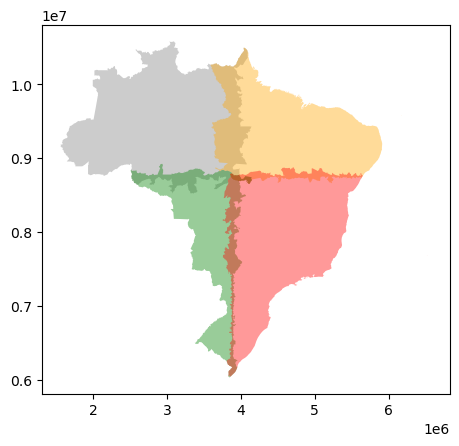

In [50]:
base=Brazil_topLeft.plot(facecolor='grey', alpha=0.4)
Brazil_topRight.plot(ax=base,facecolor='orange', alpha=0.4)
Brazil_bottomLeft.plot(ax=base,facecolor='green', alpha=0.4)
Brazil_bottomRight.plot(ax=base,facecolor='red', alpha=0.4)

### Exercise 4


<div class="alert-success"> 

1. Compute the centroid of your country.

2. Combine all the polygons to the north, and also all the polygons to the south; use unary union.

3. Detect the amount of duplicates after the combination.

4. Plot both maps so that duplicates appear.
    
</div>

<a class="anchor" id="31"></a>

## Creating the convex hull

Some time you may have the need to create a polygon that serves as an envelope to a set of points:

In [51]:
Brazil_AirTopLeft=airports[airports.kind=='medium_airport'].cx[:centroidX,centroidY:]
Brazil_AirTopRight=airports[airports.kind=='medium_airport'].cx[centroidX:,centroidY:]
Brazil_AirBottomLeft=airports[airports.kind=='medium_airport'].cx[:centroidX,:centroidY]
Brazil_AirBottomRight=airports[airports.kind=='medium_airport'].cx[centroidX:,:centroidY]

<Axes: >

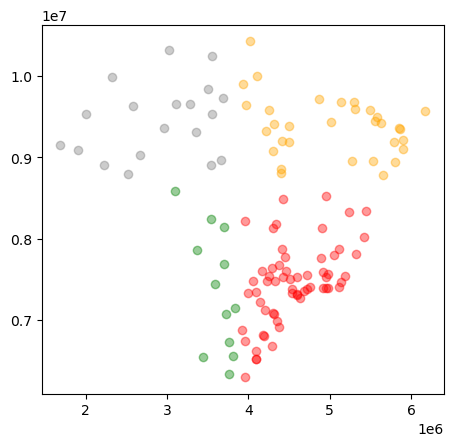

In [52]:
base=Brazil_AirTopLeft.plot(facecolor='grey', alpha=0.4)
Brazil_AirTopRight.plot(ax=base,facecolor='orange', alpha=0.4)
Brazil_AirBottomLeft.plot(ax=base,facecolor='green', alpha=0.4)
Brazil_AirBottomRight.plot(ax=base,facecolor='red', alpha=0.4)

Notice we have simple points:

In [53]:
Brazil_AirBottomLeft

name            kind  latitude_deg  \
8              Cataratas International Airport  medium_airport    -25.594167   
15                        Campo Grande Airport  medium_airport    -20.469998   
22                     Marechal Rondon Airport  medium_airport    -15.652900   
52   Coronel Adalberto Mendes da Silva Airport  medium_airport    -25.000323   
71              Maestro Marinho Franco Airport  medium_airport    -16.584292   
83                          Ponta Porã Airport  medium_airport    -22.549601   
85                        Santo Ângelo Airport  medium_airport    -28.282503   
90                  Brigadeiro Camarão Airport  medium_airport    -12.694400   
106                        Santa Maria Airport  medium_airport    -29.711399   
149              Corumbá International Airport  medium_airport    -19.011930   
155                        Rubem Berta Airport  medium_airport    -29.782200   
244         Comandante Gustavo Kraemer Airport  medium_airport    -31.390499   

     longitude_deg  elevation_ft         region_name   municipality  \
8       -54.489444         786.0              Paraná  Foz do Iguaçu   
15      -54.673988        1833.0  Mato Grosso do Sul   Campo Grande   
22      -56.116699         617.0         Mato Grosso         Cuiabá   
52      -53.501208        2481.0              Paraná       Cascavel   
71      -54.724803        1467.0         Mato Grosso   Rondonópolis   
83      -55.702599        2156.0  Mato Grosso do Sul     Ponta Porã   
85      -54.169623        1056.0   Rio Grande do Sul   Santo Ângelo   
90      -60.098301        2018.0            Rondônia        Vilhena   
106     -53.688202         287.0   Rio Grande do Sul    Santa Maria   
149     -57.672772         463.0  Mato Grosso do Sul        Corumbá   
155     -57.038200         256.0   Rio Grande do Sul     Uruguaiana   
244     -54.112202         600.0   Rio Grande do Sul           Bagé   

                            geometry  
8    POINT (3721774.865 7071323.040)  
15   POINT (3701243.952 7687543.733)  
22   POINT (3540739.278 8248021.581)  
52   POINT (3831718.226 7143997.144)  
71   POINT (3695590.675 8140827.535)  
83   POINT (3586808.785 7440288.417)  
85   POINT (3757355.633 6737578.539)  
90   POINT (3097777.568 8585400.848)  
106  POINT (3810914.745 6556752.132)  
149  POINT (3367622.840 7858868.554)  
155  POINT (3438220.327 6547725.745)  
244  POINT (3763743.842 6340901.399)

In this situation, you can not make a _convex hull_:

<Axes: >

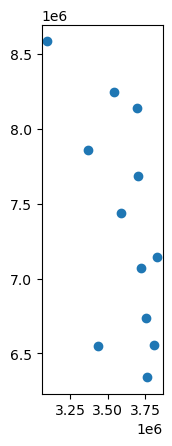

In [54]:
Brazil_AirBottomLeft.convex_hull.plot()

You first need to dissolve, and then you create a hull, an envelope of  convex angles:

<Axes: >

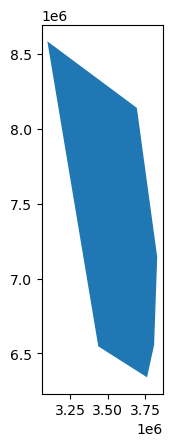

In [55]:
Brazil_AirBottomLeft.dissolve().convex_hull.plot()

As we saw, the convex hull is a polygon: 

In [56]:
Brazil_AirBottomLeft.dissolve().convex_hull

0    POLYGON ((3763743.842 6340901.399, 3438220.327...
dtype: geometry

We can make hulls from any spatial object:

<Axes: >

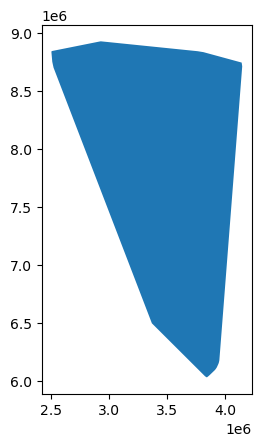

In [57]:
# SW of Brazil as convex hull
Brazil_bottomLeft.convex_hull.plot()

In this last case, what if we the polygons had not been previously combined?

<Axes: >

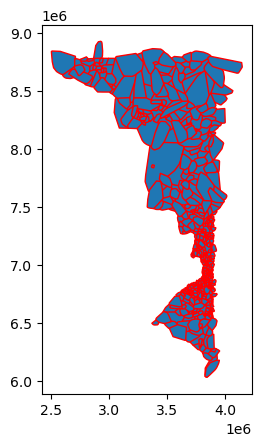

In [58]:
brazil_municipalities.cx[:centroidX,:centroidY].convex_hull.plot(edgecolor='red')

That is, you get a convex hull for each geometry. 

We can also use _union_ before creating a convex hull:

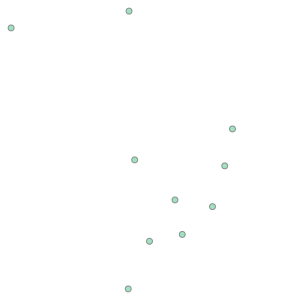

In [59]:
# just the union
large_airport=airports[airports.kind=='large_airport']
large_airport.unary_union

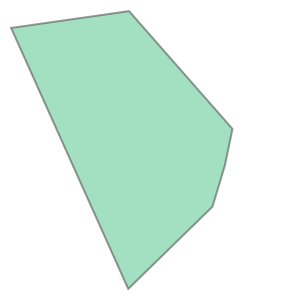

In [60]:
# hull of the union
large_airport.unary_union.convex_hull

Let's turn the GS into a GDF:

In [61]:
LargeAirport_hull= gpd.GeoDataFrame(index=[0],
                                    crs=large_airport.crs,
                                    geometry=[large_airport.unary_union.convex_hull])
LargeAirport_hull['name']='large airports hull' # optional

# then

LargeAirport_hull

geometry                 name
0  POLYGON ((4382272.317 6814299.684, 3103184.311...  large airports hull

Let's use the GDF in plotting:

<Axes: >

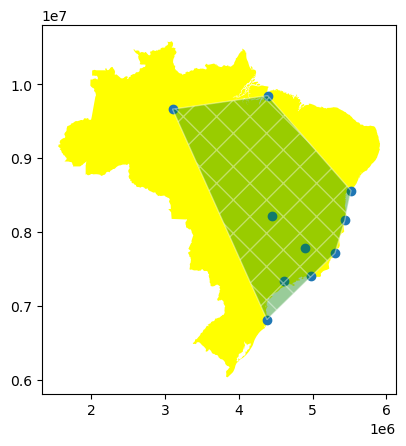

In [62]:
base=brazil.plot(facecolor='yellow')
large_airport.plot(ax=base)
LargeAirport_hull.plot(ax=base,facecolor='green',
                       edgecolor='white',alpha=0.4,
                       hatch='X')

### Exercise 5 

<div class="alert-success">

1. Select some points from your maps.
    
2. Create the convex hull for those points.
    
3. Turn the hull into a GDF.
    
4. Plot the hull on top of the country.
    
</div>

## Spatial Overlay

We might need to create or find some geometries from the geometries we already have. Using a set theory approach, we will se the use of _intersection_, _union_, _difference_, and _symmetric difference_.

Let me create this GeoDFs:

In [63]:
# the north
MunisN_brazil=brazil_municipalities.cx[:,centroidY:]
# the south
MunisS_brazil=brazil_municipalities.cx[:,:centroidY]
# the west
MunisW_brazil=brazil_municipalities.cx[:centroidX,:]
# the east
MunisE_brazil=brazil_municipalities.cx[centroidX:,:]

### Intersection

We keep what is common in both GeoDFs:

In [64]:
munisMidNS_brazil=MunisN_brazil.overlay(MunisS_brazil, how="intersection",keep_geom_type=True)
munisMidNS_brazil

C:\Users\HP\anaconda3\envs\NicoNicoNi\Lib\site-packages\geopandas\geodataframe.py:1815: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union


ADM0_EN_1 ADM0_PT_1 ADM0_PCODE_1    ADM1_PT_1 ADM1_PCODE_1  \
0     Brazil    Brasil           BR     Rondônia         BR11   
1     Brazil    Brasil           BR     Rondônia         BR11   
2     Brazil    Brasil           BR     Rondônia         BR11   
3     Brazil    Brasil           BR     Rondônia         BR11   
4     Brazil    Brasil           BR     Rondônia         BR11   
..       ...       ...          ...          ...          ...   
60    Brazil    Brasil           BR  Mato Grosso         BR51   
61    Brazil    Brasil           BR  Mato Grosso         BR51   
62    Brazil    Brasil           BR  Mato Grosso         BR51   
63    Brazil    Brasil           BR  Mato Grosso         BR51   
64    Brazil    Brasil           BR  Mato Grosso         BR51   

             ADM2_PT_1 ADM2_PCODE_1  ET_ID_1 ADM0_EN_2 ADM0_PT_2 ADM0_PCODE_2  \
0               Cacoal    BR1100049        3    Brazil    Brasil           BR   
1      Espigão D'Oeste    BR1100098        8    Brazil    Brasil           BR   
2    Presidente Médici    BR1100254       17    Brazil    Brasil           BR   
3   Ministro Andreazza    BR1101203       37    Brazil    Brasil           BR   
4              Vilhena    BR1100304       21    Brazil    Brasil           BR   
..                 ...          ...      ...       ...       ...          ...   
60             Cláudia    BR5103056     5213    Brazil    Brasil           BR   
61              Itaúba    BR5104559     5236    Brazil    Brasil           BR   
62   Nova Santa Helena    BR5106190     5258    Brazil    Brasil           BR   
63         Feliz Natal    BR5103700     5226    Brazil    Brasil           BR   
64         Marcelândia    BR5105580     5249    Brazil    Brasil           BR   

      ADM1_PT_2 ADM1_PCODE_2           ADM2_PT_2 ADM2_PCODE_2  ET_ID_2  \
0      Rondônia         BR11              Cacoal    BR1100049        3   
1      Rondônia         BR11     Espigão D'Oeste    BR1100098        8   
2      Rondônia         BR11   Presidente Médici    BR1100254       17   
3      Rondônia         BR11  Ministro Andreazza    BR1101203       37   
4      Rondônia         BR11             Vilhena    BR1100304       21   
..          ...          ...                 ...          ...      ...   
60  Mato Grosso         BR51             Cláudia    BR5103056     5213   
61  Mato Grosso         BR51              Itaúba    BR5104559     5236   
62  Mato Grosso         BR51   Nova Santa Helena    BR5106190     5258   
63  Mato Grosso         BR51         Feliz Natal    BR5103700     5226   
64  Mato Grosso         BR51         Marcelândia    BR5105580     5249   

                                             geometry  
0   POLYGON ((2997393.730 8770664.256, 2997393.730...  
1   POLYGON ((3056978.535 8777571.933, 3056645.811...  
2   POLYGON ((2914558.967 8738429.583, 2915047.868...  
3   POLYGON ((2943634.994 8778259.184, 2949854.901...  
4   MULTIPOLYGON (((3064936.757 8679749.203, 30646...  
..                                                ...  
60  MULTIPOLYGON (((3633698.340 8745495.507, 36341...  
61  POLYGON ((3597587.572 8781564.662, 3598001.779...  
62  POLYGON ((3708398.334 8822508.817, 3707916.224...  
63  MULTIPOLYGON (((3771432.608 8649297.202, 37709...  
64  POLYGON ((3876654.961 8801397.454, 3876573.477...  

[65 rows x 17 columns]

This is similar to a _spatial join_:

In [65]:
MunisN_brazil.sjoin(MunisS_brazil, how="inner", predicate='contains')

ADM0_EN_left ADM0_PT_left ADM0_PCODE_left ADM1_PT_left ADM1_PCODE_left  \
3          Brazil       Brasil              BR     Rondônia            BR11   
8          Brazil       Brasil              BR     Rondônia            BR11   
9          Brazil       Brasil              BR     Rondônia            BR11   
11         Brazil       Brasil              BR     Rondônia            BR11   
17         Brazil       Brasil              BR     Rondônia            BR11   
...           ...          ...             ...          ...             ...   
5247       Brazil       Brasil              BR  Mato Grosso            BR51   
5249       Brazil       Brasil              BR  Mato Grosso            BR51   
5258       Brazil       Brasil              BR  Mato Grosso            BR51   
5305       Brazil       Brasil              BR  Mato Grosso            BR51   
5310       Brazil       Brasil              BR  Mato Grosso            BR51   

               ADM2_PT_left ADM2_PCODE_left  ET_ID_left  \
3                    Cacoal       BR1100049           3   
8           Espigão D'Oeste       BR1100098           8   
9             Guajará-Mirim       BR1100106           9   
11                Ji-Paraná       BR1100122          11   
17        Presidente Médici       BR1100254          17   
...                     ...             ...         ...   
5247                Luciara       BR5105309        5247   
5249            Marcelândia       BR5105580        5249   
5258      Nova Santa Helena       BR5106190        5258   
5305  São Félix do Araguaia       BR5107859        5305   
5310               Tabaporã       BR5107941        5310   

                                               geometry  index_right  \
3     POLYGON ((2997393.730 8777661.276, 2997393.730...            3   
8     POLYGON ((3057637.194 8777929.305, 3056978.535...            8   
9     MULTIPOLYGON (((2708460.048 8727087.796, 27089...            9   
11    POLYGON ((2933666.847 8920914.042, 2933571.782...           11   
17    POLYGON ((2914898.482 8739124.549, 2914558.967...           17   
...                                                 ...          ...   
5247  POLYGON ((4154126.631 8815123.058, 4154004.406...         5247   
5249  POLYGON ((3876675.331 8801946.860, 3876654.961...         5249   
5258  POLYGON ((3708961.928 8822632.357, 3708398.334...         5258   
5305  POLYGON ((3974265.397 8773180.057, 3974197.494...         5305   
5310  POLYGON ((3505714.931 8812411.339, 3505972.962...         5310   

     ADM0_EN_right ADM0_PT_right ADM0_PCODE_right ADM1_PT_right  \
3           Brazil        Brasil               BR      Rondônia   
8           Brazil        Brasil               BR      Rondônia   
9           Brazil        Brasil               BR      Rondônia   
11          Brazil        Brasil               BR      Rondônia   
17          Brazil        Brasil               BR      Rondônia   
...            ...           ...              ...           ...   
5247        Brazil        Brasil               BR   Mato Grosso   
5249        Brazil        Brasil               BR   Mato Grosso   
5258        Brazil        Brasil               BR   Mato Grosso   
5305        Brazil        Brasil               BR   Mato Grosso   
5310        Brazil        Brasil               BR   Mato Grosso   

     ADM1_PCODE_right          ADM2_PT_right ADM2_PCODE_right  ET_ID_right  
3                BR11                 Cacoal        BR1100049            3  
8                BR11        Espigão D'Oeste        BR1100098            8  
9                BR11          Guajará-Mirim        BR1100106            9  
11               BR11              Ji-Paraná        BR1100122           11  
17               BR11      Presidente Médici        BR1100254           17  
...               ...                    ...              ...          ...  
5247             BR51                Luciara        BR5105309         5247  
5249             BR51            Marcelândia        BR5105580

C:\Users\HP\anaconda3\envs\NicoNicoNi\Lib\site-packages\geopandas\geodataframe.py:1815: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union


<Axes: >

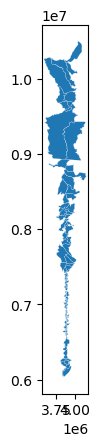

In [66]:
# keeping the overlay
munisMidWE_brazil=MunisW_brazil.overlay(MunisE_brazil, how="intersection",keep_geom_type=True)
munisMidWE_brazil.plot(edgecolor='white',linewidth=0.1)

### Union

Let me unite the previous two GeoDFs. First, take a look at each one:

In [67]:
munisMidNS_brazil.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   ADM0_EN_1     65 non-null     object  
 1   ADM0_PT_1     65 non-null     object  
 2   ADM0_PCODE_1  65 non-null     object  
 3   ADM1_PT_1     65 non-null     object  
 4   ADM1_PCODE_1  65 non-null     object  
 5   ADM2_PT_1     65 non-null     object  
 6   ADM2_PCODE_1  65 non-null     object  
 7   ET_ID_1       65 non-null     int64   
 8   ADM0_EN_2     65 non-null     object  
 9   ADM0_PT_2     65 non-null     object  
 10  ADM0_PCODE_2  65 non-null     object  
 11  ADM1_PT_2     65 non-null     object  
 12  ADM1_PCODE_2  65 non-null     object  
 13  ADM2_PT_2     65 non-null     object  
 14  ADM2_PCODE_2  65 non-null     object  
 15  ET_ID_2       65 non-null     int64   
 16  geometry      65 non-null     geometry
dtypes: geometry(1), int64(2), object(14)
memory usag

In [68]:
munisMidWE_brazil.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   ADM0_EN_1     115 non-null    object  
 1   ADM0_PT_1     115 non-null    object  
 2   ADM0_PCODE_1  115 non-null    object  
 3   ADM1_PT_1     115 non-null    object  
 4   ADM1_PCODE_1  115 non-null    object  
 5   ADM2_PT_1     115 non-null    object  
 6   ADM2_PCODE_1  115 non-null    object  
 7   ET_ID_1       115 non-null    int64   
 8   ADM0_EN_2     115 non-null    object  
 9   ADM0_PT_2     115 non-null    object  
 10  ADM0_PCODE_2  115 non-null    object  
 11  ADM1_PT_2     115 non-null    object  
 12  ADM1_PCODE_2  115 non-null    object  
 13  ADM2_PT_2     115 non-null    object  
 14  ADM2_PCODE_2  115 non-null    object  
 15  ET_ID_2       115 non-null    int64   
 16  geometry      115 non-null    geometry
dtypes: geometry(1), int64(2), object(14)
memory us

The overlay combines the geometries, but not the attributes. Let me subset and show you:

In [69]:
keep=['ADM0_EN_1','ADM1_PT_1','ADM2_PT_1','geometry']
munisMidNS_brazil=munisMidNS_brazil.loc[:,keep]
munisMidWE_brazil=munisMidWE_brazil.loc[:,keep]


In [70]:
# now 
munisMidNS_brazil.overlay(munisMidWE_brazil,how="union",keep_geom_type=True)

ADM0_EN_1_1  ADM1_PT_1_1            ADM2_PT_1_1 ADM0_EN_1_2  ADM1_PT_1_2  \
0        Brazil  Mato Grosso  São Félix do Araguaia      Brazil  Mato Grosso   
1        Brazil     Rondônia                 Cacoal         NaN          NaN   
2        Brazil     Rondônia        Espigão D'Oeste         NaN          NaN   
3        Brazil     Rondônia      Presidente Médici         NaN          NaN   
4        Brazil     Rondônia     Ministro Andreazza         NaN          NaN   
..          ...          ...                    ...         ...          ...   
174         NaN          NaN                    NaN      Brazil  Mato Grosso   
175         NaN          NaN                    NaN      Brazil  Mato Grosso   
176         NaN          NaN                    NaN      Brazil  Mato Grosso   
177         NaN          NaN                    NaN      Brazil  Mato Grosso   
178         NaN          NaN                    NaN      Brazil  Mato Grosso   

               ADM2_PT_1_2                                           geometry  
0    São Félix do Araguaia  POLYGON ((3974842.572 8772389.594, 3975012.329...  
1                      NaN  POLYGON ((2997393.730 8770664.256, 2997393.730...  
2                      NaN  POLYGON ((3056978.535 8777571.933, 3056645.811...  
3                      NaN  POLYGON ((2914558.967 8738429.583, 2915047.868...  
4                      NaN  POLYGON ((2943634.994 8778259.184, 2949854.901...  
..                     ...                                                ...  
174     Pontal do Araguaia  POLYGON ((3915767.038 8240179.071, 3916215.197...  
175        Gaúcha do Norte  POLYGON ((3822074.600 8649214.391, 3822339.421...  
176              Querência  MULTIPOLYGON (((3915882.473 8591396.795, 39154...  
177                Tesouro  POLYGON ((3872193.739 8238559.612, 3872628.318...  
178      São José do Xingu  POLYGON ((3981564.960 8856938.657, 3981517.428...  

[179 rows x 7 columns]

As you see, geometries are fine, but not attributes. It is strictly NOT appending the GeoDFs:

In [71]:
# appending
pd.concat([munisMidNS_brazil,munisMidWE_brazil],ignore_index=True)

ADM0_EN_1    ADM1_PT_1              ADM2_PT_1  \
0      Brazil     Rondônia                 Cacoal   
1      Brazil     Rondônia        Espigão D'Oeste   
2      Brazil     Rondônia      Presidente Médici   
3      Brazil     Rondônia     Ministro Andreazza   
4      Brazil     Rondônia                Vilhena   
..        ...          ...                    ...   
175    Brazil  Mato Grosso        Gaúcha do Norte   
176    Brazil  Mato Grosso              Querência   
177    Brazil  Mato Grosso  São Félix do Araguaia   
178    Brazil  Mato Grosso                Tesouro   
179    Brazil  Mato Grosso      São José do Xingu   

                                              geometry  
0    POLYGON ((2997393.730 8770664.256, 2997393.730...  
1    POLYGON ((3056978.535 8777571.933, 3056645.811...  
2    POLYGON ((2914558.967 8738429.583, 2915047.868...  
3    POLYGON ((2943634.994 8778259.184, 2949854.901...  
4    MULTIPOLYGON (((3064936.757 8679749.203, 30646...  
..                                                 ...  
175  POLYGON ((3822074.600 8649214.391, 3822339.421...  
176  MULTIPOLYGON (((3916636.195 8591168.612, 39162...  
177  POLYGON ((3974197.494 8772623.298, 3974842.572...  
178  POLYGON ((3872193.739 8238559.612, 3872628.318...  
179  POLYGON ((3981632.863 8858364.779, 3981422.364...  

[180 rows x 4 columns]

You will append if you are interested in the keeping the attributes. But you just do the overlay if you are planing to combine final results:

<Axes: >

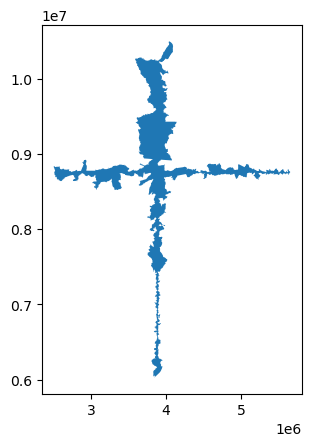

In [72]:
munisMidNS_brazil.dissolve().overlay(munisMidWE_brazil.dissolve(), how="union",keep_geom_type=True).dissolve().plot()

Let me create an object to save the previous result:

In [73]:
muniMidBrazil=munisMidNS_brazil.dissolve().overlay(munisMidWE_brazil.dissolve(), how="union",keep_geom_type=True).dissolve()
muniMidBrazil

geometry ADM0_EN_1_1 ADM1_PT_1_1  \
0  MULTIPOLYGON (((3873395.621 6740520.149, 38739...      Brazil    Rondônia   

  ADM2_PT_1_1 ADM0_EN_1_2 ADM1_PT_1_2 ADM2_PT_1_2  
0      Cacoal      Brazil        Pará    Almeirim

In [74]:
# some cleaning

muniMidBrazil['zone']='middles'
muniMidBrazil=muniMidBrazil.loc[:,['ADM0_EN_1_1','zone','geometry']]   
muniMidBrazil

ADM0_EN_1_1     zone                                           geometry
0      Brazil  middles  MULTIPOLYGON (((3873395.621 6740520.149, 38739...

### Difference

Here, you keep what belongs to the GeoDF to left that is not in the GeoDF to the right:

<Axes: >

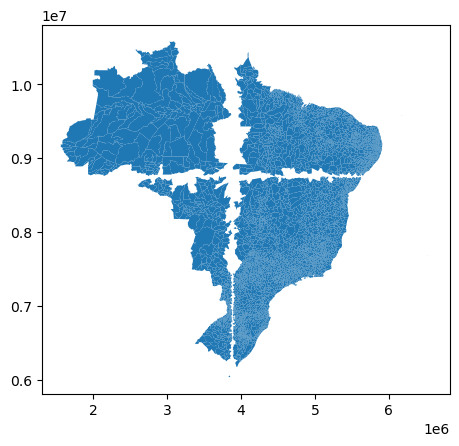

In [75]:
# with the municipalities
brazil_municipalities.overlay(muniMidBrazil, how='difference').plot()

<Axes: >

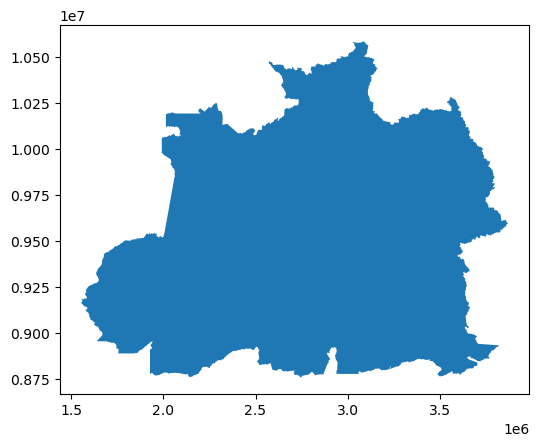

In [76]:
# with the zones
Brazil_topLeft.overlay(muniMidBrazil, how='difference').plot()

### Symmetric Difference

This is the opposite to *intersection*, you keep what is not in the intersection:

<Axes: >

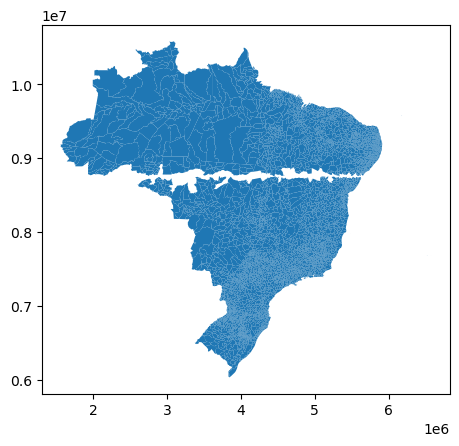

In [77]:
MunisN_brazil.overlay(MunisS_brazil, how="symmetric_difference",keep_geom_type=False).plot()

In [ ]:
MunisW_brazil.overlay(MunisE_brazil, how="symmetric_difference",keep_geom_type=False).plot()

### Exercise 6 

<div class="alert-success">

1. Apply two of these operations to your maps.
2. Apply two of these operations to the  next maps:
        
</div>

In [ ]:
# hulls for the mid size airports:
Brazil_AirTopLeft_hull=Brazil_AirTopLeft.dissolve().convex_hull
Brazil_AirTopRight_hull=Brazil_AirTopRight.dissolve().convex_hull
Brazil_AirBottomLeft_hull=Brazil_AirBottomLeft.dissolve().convex_hull
Brazil_AirBottomRight_hull=Brazil_AirBottomRight.dissolve().convex_hull

In [ ]:
base = brazil.plot(color='white', edgecolor='black') #unprojected
muniMidBrazil.plot(ax=base,facecolor='magenta',alpha=0.4) #unprojected
LargeAirport_hull.plot(ax=base,facecolor='purple',alpha=0.4)
Brazil_AirTopLeft_hull.plot(ax=base,facecolor='grey', alpha=0.4)
Brazil_AirTopRight_hull.plot(ax=base,facecolor='orange', alpha=0.4)
Brazil_AirBottomLeft_hull.plot(ax=base,facecolor='green', alpha=0.4)
Brazil_AirBottomRight_hull.plot(ax=base,facecolor='red', alpha=0.4)

<a class="anchor" id="4"></a>

## Validity of Geometry

Geometries are created in a way that some issues may appear, especially in (multi) polygons.
Let's check if our recent maps on states and municipalities are valid:

In [ ]:
# non valid
brazil_municipalities[~brazil_municipalities.is_valid]

In [ ]:
# see the invalid:
brazil_municipalities[~brazil_municipalities.is_valid].plot()

It is difficult to see what is wrong. Let's get some information:

In [ ]:
# what is wrong?

from shapely.validation import explain_validity, make_valid

explain_validity(brazil_municipalities[~brazil_municipalities.is_valid].geometry)

In [ ]:
# varieties?
brazil_municipalities['validity']=[x.split('[')[0] for x in brazil_municipalities.geometry.apply(lambda x: explain_validity(x))]
brazil_municipalities['validity'].value_counts()

In [ ]:
# solving the issue:
brazil_municipalities.drop(columns=['validity'],inplace=True)

brazil_municipalities_valid=brazil_municipalities.copy()

brazil_municipalities_valid['geometry'] = [make_valid(row)  if not row.is_valid else row for row in brazil_municipalities_valid['geometry'] ]
#any invalid?
brazil_municipalities_valid[~brazil_municipalities_valid.is_valid]

The _solution_ we got may help for some advanced techniques, but may also give us some extra trouble. Notice that once geopandas solved the problem, you  have created **collections**:

In [ ]:
[x for x in brazil_municipalities_valid["geometry"]]

In [ ]:
pd.Series([type(x) for x in brazil_municipalities_valid.geometry]).value_counts()

In [ ]:
# brazil.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"),layer='country', driver="GPKG")
# brazil_cities.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"),layer='cities', driver="GPKG")
# brazil_rivers.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"),layer='rivers', driver="GPKG")
# airports.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"),layer='airports', driver="GPKG")
# brazil_border.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"), layer='border', driver="GPKG")
# brazil_states.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"), layer='states', driver="GPKG")
# brazil_municipalities.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"), layer='municipalities', driver="GPKG")